<a href="https://colab.research.google.com/github/raultyv/Machine_learning/blob/main/Prediccion_lluvia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. INSTALACIÓN (Solo si no las instalaste antes, si ya están, puedes saltar esta parte)
!pip install openmeteo-requests requests-cache retry-requests folium pandas matplotlib -q

import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import folium
import matplotlib.pyplot as plt
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.7/684.7 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.1/394.1 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 11.9 MB/s eta 0:00:00


Disclaimer (Descargo de Responsabilidad)
Aviso Importante: Esta herramienta es de carácter informativo y se basa en modelos matemáticos atmosféricos que representan probabilidades, no certezas. Las condiciones meteorológicas en zonas de alta montaña (como los Andes Peruanos) son altamente complejas y pueden variar rápidamente debido a factores locales como la topografía y microclimas no capturados por modelos globales.

Los resultados aquí mostrados no reemplazan las alertas oficiales emitidas por el SENAMHI ni deben ser la única base para la toma de decisiones que comprometan la seguridad de personas o activos.

/tmp/ipython-input-1854867516.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "fecha_hora": pd.date_range(
/tmp/ipython-input-1854867516.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_senamhi = df_hourly.resample('24H', on='fecha_hora', offset='7H').sum().reset_index().head(15)
/tmp/ipython-input-1854867516.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  df_senamhi = df_hourly.resample('24H', on='fecha_hora', offset='7H').sum().reset_index().head(15)



📊 Generando reporte visual...


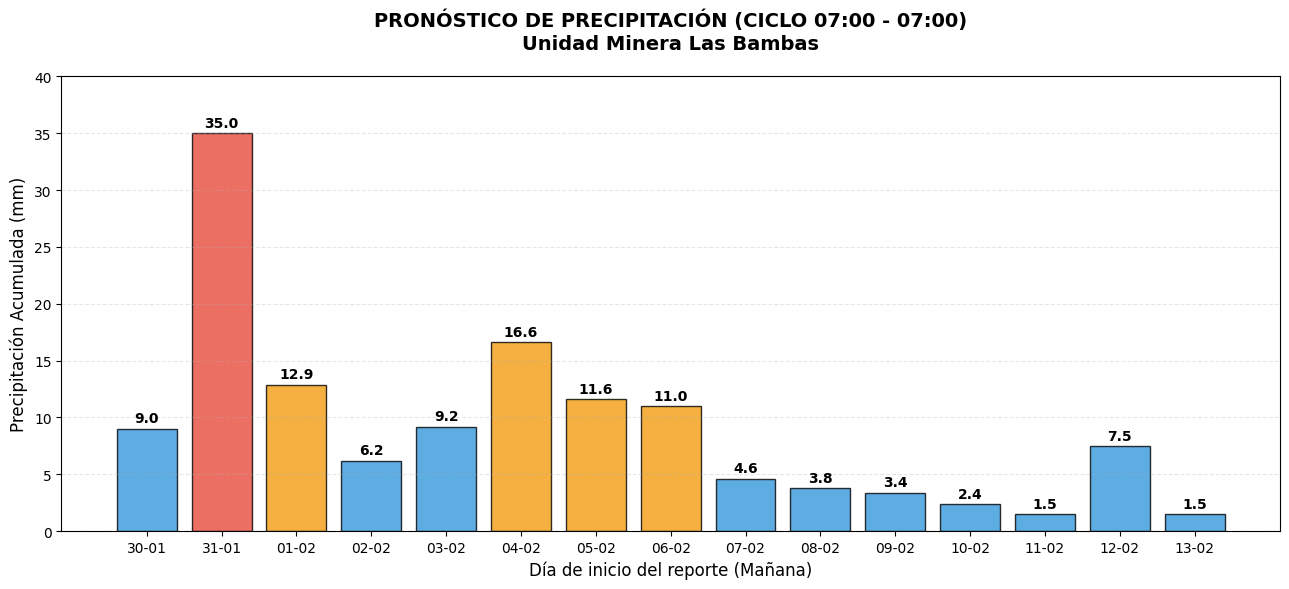


   RESUMEN DE ACUMULADOS CRÍTICOS (LAS BAMBAS)
🌧️ Próximos 5 días:  72.3 mm
🌧️ Próximos 10 días: 119.9 mm
🌧️ Próximos 15 días: 136.2 mm


In [4]:


# Comando para asegurar visualización en Colab
%matplotlib inline

# 2. CONFIGURACIÓN LAS BAMBAS
LAT_BAMBAS, LON_BAMBAS = -14.0989, -72.3197
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# 3. OBTENCIÓN DE DATOS
params = {
    "latitude": LAT_BAMBAS,
    "longitude": LON_BAMBAS,
    "hourly": "precipitation",
    "timezone": "America/Lima",
    "forecast_days": 16
}
responses = openmeteo.weather_api("https://api.open-meteo.com/v1/forecast", params=params)
response = responses[0]

# 4. PROCESAMIENTO (ESTÁNDAR 07:00 A 07:00)
hourly = response.Hourly()
hourly_precip = hourly.Variables(0).ValuesAsNumpy()
inicio_utc = pd.to_datetime(hourly.Time(), unit="s", utc=True)

df_hourly = pd.DataFrame({
    "fecha_hora": pd.date_range(
        start=inicio_utc,
        periods=len(hourly_precip),
        freq="H"
    ).tz_convert('America/Lima'),
    "precipitacion": hourly_precip
})

# Agrupación diaria estándar SENAMHI
df_senamhi = df_hourly.resample('24H', on='fecha_hora', offset='7H').sum().reset_index().head(15)
df_senamhi['Lluvia_mm'] = df_senamhi['precipitacion'].round(1)

# 5. GRÁFICO DE BARRAS CON UN DECIMAL
print("\n📊 Generando reporte visual...")
fig, ax = plt.subplots(figsize=(13, 6))

fechas_labels = df_senamhi['fecha_hora'].dt.strftime('%d-%m')
valores = df_senamhi['Lluvia_mm']

# Colores por intensidad
colores = ['#3498db' if x < 10 else '#f39c12' if x < 25 else '#e74c3c' for x in valores]

bars = ax.bar(fechas_labels, valores, color=colores, edgecolor='black', alpha=0.8)

# Configuración de ejes
ax.set_title('PRONÓSTICO DE PRECIPITACIÓN (CICLO 07:00 - 07:00)\nUnidad Minera Las Bambas', fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel('Precipitación Acumulada (mm)', fontsize=12)
ax.set_xlabel('Día de inicio del reporte (Mañana)', fontsize=12)
ax.set_ylim(0, max(valores) + 5) # Espacio para las etiquetas
ax.grid(axis='y', linestyle='--', alpha=0.3)

# ETIQUETAS CON UN DECIMAL: Aquí forzamos el formato ".1f"
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.3, f'{yval:.1f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

# 6. RESUMEN DE ACUMULADOS
print("\n" + "="*65)
print(f"   RESUMEN DE ACUMULADOS CRÍTICOS (LAS BAMBAS)")
print("="*65)
print(f"🌧️ Próximos 5 días:  {df_senamhi.iloc[:5]['Lluvia_mm'].sum():.1f} mm")
print(f"🌧️ Próximos 10 días: {df_senamhi.iloc[:10]['Lluvia_mm'].sum():.1f} mm")
print(f"🌧️ Próximos 15 días: {df_senamhi.iloc[:15]['Lluvia_mm'].sum():.1f} mm")
print("="*65)

# 7. MAPA DE REFERENCIA
m = folium.Map(location=[LAT_BAMBAS, LON_BAMBAS], zoom_start=11)
folium.Marker([LAT_BAMBAS, LON_BAMBAS], popup="Punto de Monitoreo Las Bambas", icon=folium.Icon(color='red', icon='info-sign')).add_to(m)
display(m)

Especificaciones Técnicas del Dataset
1. Origen y Fuente de los Datos
La información se extrae mediante la API de Open-Meteo, una plataforma de datos meteorológicos de código abierto que integra y post-procesa resultados de los modelos numéricos de predicción del tiempo (NWP) más avanzados del mundo:

Modelo Principal: ECMWF (European Centre for Medium-Range Weather Forecasts). Es considerado el estándar en la industria meteorológica por su precisión en latitudes tropicales y zonas complejas.

Modelo de Respaldo: GFS (Global Forecast System - NOAA). Utilizado para la validación de tendencias de largo plazo.

2. Resolución y Cobertura
Resolución Espacial: Los datos operan bajo una malla de 0.1° arcodegrees, lo que equivale aproximadamente a 11 km x 11 km. El pronóstico representa el promedio del área de dicha celda sobre las coordenadas de la unidad minera.

Resolución Temporal: Los datos originales son horarios. El script procesa estas 24 celdas horarias para conformar el acumulado diario bajo el estándar de medición oficial.

3. Estándar Hidrológico (Perú)
A diferencia de los reportes automáticos de teléfonos o webs genéricas (que cortan el día a la medianoche), este dataset ha sido programado para seguir el protocolo del SENAMHI:

Ciclo de 24 horas: De 07:00 AM a 07:00 AM del día siguiente.

Zona Horaria: Ajustada dinámicamente a America/Lima (UTC-5).

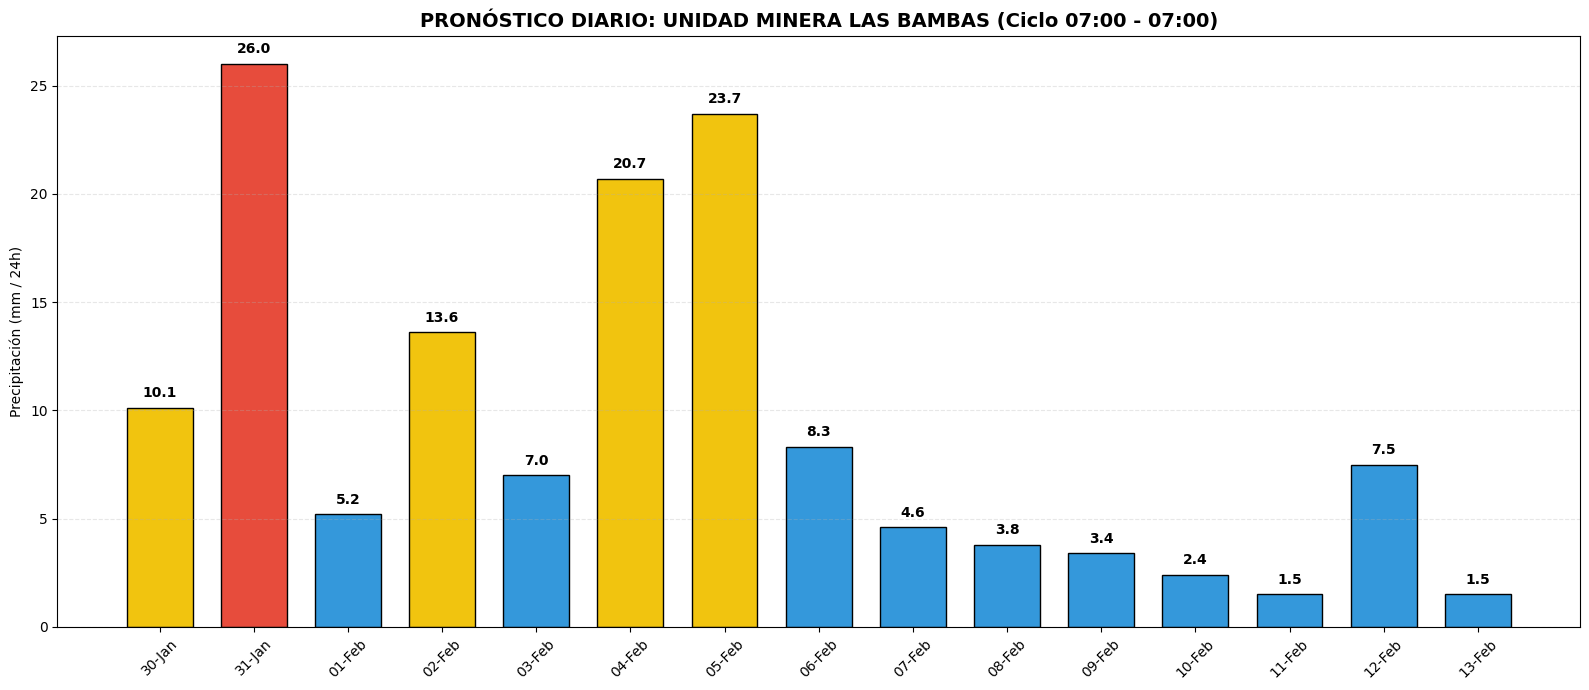


✅ REPORTE COMPLETO GENERADO
Punto de Control: -14.0989, -72.3197 (Apurímac, Perú)


In [26]:
import openmeteo_requests
import requests_cache
import pandas as pd
import matplotlib.pyplot as plt
import folium
from retry_requests import retry

# 1. COORDENADAS DE EXTRACCIÓN (Las Bambas)
LAT, LON = -14.0989, -72.3197

# 2. CONFIGURACIÓN DE DATOS
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

params = {
    "latitude": LAT, "longitude": LON,
    "hourly": "precipitation", "timezone": "UTC", "forecast_days": 16
}

try:
    responses = openmeteo.weather_api("https://api.open-meteo.com/v1/forecast", params=params)
    hourly = responses[0].Hourly()
    precip_values = hourly.Variables(0).ValuesAsNumpy()

    # 3. PROCESAMIENTO: UTC a LIMA y AJUSTE 07:00 AM
    start_time = pd.to_datetime(hourly.Time(), unit="s", utc=True)
    tiempos_lima = pd.date_range(start=start_time, periods=len(precip_values), freq='h').tz_convert('America/Lima')

    df = pd.DataFrame({"lluvia": precip_values}, index=tiempos_lima)
    # Restamos 7h: La lluvia del 31 a las 5am se registra como el día 30
    df['dia_operativo'] = (df.index - pd.Timedelta(hours=7)).date

    # 4. AGRUPACIÓN SEGMENTADA (Evita la barra única)
    df_diario = df.groupby('dia_operativo')['lluvia'].sum().reset_index().head(15)
    df_diario['lluvia'] = df_diario['lluvia'].round(1)

    # 5. VISUALIZACIÓN 1: GRÁFICO DE BARRAS LIMPIO
    plt.figure(figsize=(16, 7))
    etiquetas = [d.strftime('%d-%b') for d in df_diario['dia_operativo']]
    valores = df_diario['lluvia'].tolist()
    colores = ['#3498db' if x < 10 else '#f1c40f' if x < 25 else '#e74c3c' for x in valores]

    bars = plt.bar(etiquetas, valores, color=colores, edgecolor='black', width=0.7)
    plt.title(f'PRONÓSTICO DIARIO: UNIDAD MINERA LAS BAMBAS (Ciclo 07:00 - 07:00)', fontsize=14, fontweight='bold')
    plt.ylabel('Precipitación (mm / 24h)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.1f}', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # 6. VISUALIZACIÓN 2: MAPA DE UBICACIÓN
    mapa = folium.Map(location=[LAT, LON], zoom_start=12, control_scale=True)
    folium.Marker(
        [LAT, LON],
        popup="Punto de Descarga: Las Bambas",
        tooltip="Click para ver coordenadas",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(mapa)

    print(f"\n✅ REPORTE COMPLETO GENERADO")
    print(f"Punto de Control: {LAT}, {LON} (Apurímac, Perú)")

    # Para mostrar el mapa en un entorno como Jupyter/Colab:
    display(mapa)

except Exception as e:
    print(f"❌ Error crítico: {e}")